In [32]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    #BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
from cca_zoo.model_selection import GridSearchCV
import torch.optim as optim
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
import os
from scipy.spatial import distance
from scipy.stats import pearsonr
from scipy.stats import fisher_exact
from scipy.stats.contingency import crosstab
from scipy.stats import hypergeom
import random
import pandas as pd
import numpy as np
import pickle
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import seed_everything
from torch import nn
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.integration.pytorch_lightning import tune
os.chdir('../raw_data')

In [22]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        

In [62]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()[:10000]#just a subset for scripting
df_all.shape

(10000, 8)

In [63]:
class DeepCCA:
    def __init__(self, df_all,batch_size = 768,num_workers = 6,\
                latent_dims=100, epochs=300, lr=0.001): #default dims determined after iteratin 10:50 dims 
        
        self.df_all = df_all
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.v1='ms2ds'
        self.v2 = 'mol2vec'
        
        self.epochs = epochs
        self.sdl_lr = 0.025118864315095822#0.01#lr (picked after running lr_finder)
        self.dcca_lr = 5.623413251903491e-08 #lr
        self.latent_dims=latent_dims
        self.optim = 'sgd'
        self.activation = nn.Tanh()
        self.objective = objectives.CCA
        self.encoder_1_layers = (500,500)
        self.encoder_2_layers = (500,500)
        seed_everything(15)
        
        
    def split_data(self,test_size=0.2,\
                   random_state=None,stratify=None): # thinking of removing this one
        
        if random_state != None and stratify == None:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size, random_state=random_state)
        
        elif random_state == None and stratify != None:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size,stratify=self.df_all[stratify])
        else:
            train_df, test_df = \
            train_test_split(self.df_all, test_size=test_size, random_state=42)
        
        return train_df, test_df 
    
    def gen_views(self,v1='ms2ds',v2='mol2vec'):
        
        #split test, train
        train_df, test_df= self.split_data(test_size=0.2,random_state=42)
        
        #Split train dataset into train and validation set
        train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
        
        
        #extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
        v1_train, v1_test = np.array([x for x in train_df[v1]]), np.array([x for x in test_df[v1]])
        v2_train, v2_test = np.array([x for x in train_df[v2]]), np.array([x for x in test_df[v2]])

        # validation
        v1_val, v2_val = np.array([x for x in val_df[v1]]), np.array([x for x in val_df[v2]])
        
        #update self dfs
        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df
        
        # not memory efficient !!!
        self.v1_train, self.v1_test = v1_train, v1_test
        self.v2_train, self.v2_test = v2_train, v2_test
        self.v1_val, self.v2_val = v1_val, v2_val
        
        return None
    
    def deepcca_encoders(self):
        # define encoders
        self.encoder_1 = architectures.Encoder(
                                      latent_dims = self.latent_dims, 
                                      feature_size = self.v1_size,
                                      layer_sizes = self.encoder_1_layers,
                                      activation = self.activation
                                    )
                                     
        self.encoder_2 = architectures.Encoder(
                                      latent_dims=self.latent_dims, 
                                      feature_size=self.v2_size, 
                                      layer_sizes=self.encoder_2_layers,
                                      activation = self.activation
                                     )
       
        return None#[encoder_1, encoder_2]
        
    
    def deepcca_dataloaders(self):
        
        #v1_train,v1_test, v2_train,v2_test, v1_val, v2_val = \
        self.gen_views(v1=self.v1, v2=self.v2)
        
        #creat CCA dataset 
        train_dataset = CCA_Dataset([self.v1_train, self.v2_train])
        test_dataset = CCA_Dataset([self.v1_test, self.v2_test])
        val_dataset = CCA_Dataset([self.v1_val, self.v2_val])
        
        #update features size
        self.v1_size = self.v1_train.shape[1]
        self.v2_size = self.v2_train.shape[1]
        self.N = len(train_dataset)
        
        #set N (for sdl; equal len train dataset)
        self.N = len(train_dataset)
        
        #loaders
        self.train_loader , self.val_loader = get_dataloaders(train_dataset, \
                                                    val_dataset,batch_size=self.batch_size,\
                                                    num_workers=self.num_workers,drop_last=False)
        self.test_loader = get_dataloaders(test_dataset,\
                                      batch_size=self.batch_size, \
                                      num_workers=self.num_workers,drop_last=False)
        
        
        
        
        return None
    
    
    def train_cca(self): #only for comparison with other deep models
        
       
        
        #define and train cca model
        print('\n','-'*20,'\n Training CCA\n','-'*20)
        cca = CCA(latent_dims=self.latent_dims).fit((self.v1_train, self.v2_train))
        self.cca = cca
        return None#cca
    
    def train_sdl(self, checkpoint=None, logger=None,lam=0.0001,enable_progress_bar=True ):
        
        
        # 2. SDL
        sdl = DCCA_SDL(self.latent_dims,
                       optimizer=self.optim,
                       N=self.N, 
                       encoders = [self.encoder_1,self.encoder_2],
                       lam=0.0001, 
                       lr=self.sdl_lr,
                       dropout=0.05,
                       objective=self.objective) 

        
        
        #define the trainer
        
        self.trainer = pl.Trainer(#default_root_dir=default_root_dir,
                             logger = logger,
                             max_epochs=self.epochs, #enable early stoppage instead of specifiying num epochs                           
                             log_every_n_steps=1,
                             val_check_interval = 1, #`Trainer(val_check_interval=1)` was configured so validation will run after every batch.
                             
                             callbacks=[
                                checkpoint,
                                 #pl.callbacks.early_stopping.EarlyStopping(monitor="val/l2") # early stopage to reduce overfitting
                             ],
                            enable_progress_bar=enable_progress_bar,
                            auto_lr_find = True
                                )#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting
        
        print('\n','-'*20,'\n Training SDL\n','-'*20)
        self.trainer.fit(sdl, self.train_loader,self.val_loader)
        self.sdl = sdl
        return None#sdl
    
    def train_dcca(self):
        
       
        
        # 2. DCCA
        dcca = DCCA(self.latent_dims,
                    optimizer=self.optim,
                    encoders = [self.encoder_1,self.encoder_2],
                    lr=self.dcca_lr,
                    objective=self.objective) 

        #train
        #tb_logger = pl_loggers.TensorBoardLogger(save_dir="pl_logs/dcca")
        trainer = pl.Trainer(default_root_dir="./dcca",max_epochs=self.epochs,log_every_n_steps=1)#,
        
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

        print('\n','-'*20,'\n Training DCCA\n','-'*20)
        trainer.fit(dcca, self.train_loader,self.val_loader)
        
        self.dcca = dcca
        
        return None #dcca
    
    
    
    def score(self,model,dataset): 
        """
        model: either 'cca', 'dcca', 'sdl'
        dataset: 'train', 'test', or 'val'
        
        returns: correlation 
        """
       # for cca models 
        #m = eval(model)
        
        #specify data to transform
        if dataset == 'train':
            v1,v2, loader = self.v1_train, self.v2_train, self.train_loader
        elif dataset == 'test':
            v1,v2, loader = self.v1_test, self.v2_test, self.test_loader
        elif dataset == 'val':
            v1,v2, loader = self.v1_val, self.v2_val, self.val_loader
        
        if model == 'cca':
            corr = self.cca.score([v1,v2])
        
        if model == 'sdl':
            corr = self.sdl.score(loader)
        
        elif model == 'dcca':
            corr = self.dcca.score(loader)
       
        return corr
    def update_z_scores(self,dataset, z1,z2,cols):
        #update train df with transformed z scores
            if dataset == 'train':
                
                self.train_df[cols[0]] = [x for x in z1]
                self.train_df[cols[1]] = [x for x in z2]
                
            #update test df
            if dataset == 'test':
                self.test_df[cols[0]] = [x for x in z1]
                self.test_df[cols[1]] = [x for x in z2]
            
            #update val df
            if dataset == 'val':
                self.val_df[cols[0]] = [x for x in z1]
                self.val_df[cols[1]] = [x for x in z2]
            return None
                
        
    
    def transform(self,model,dataset):
        """
        model: either 'cca', 'dcca', 'sdl': of course the model must have been fitted :)
        loader: is similar data loader used to train either sdl/dcca
        dataset: either 'train', 'test', 'val'
        
        returns transformed data; view1,view2
        """
        
        #specify data to transform
        if dataset == 'train':
            v1,v2, loader = self.v1_train, self.v2_train, self.train_loader
        elif dataset == 'test':
            v1,v2, loader = self.v1_test, self.v2_test, self.test_loader
        elif dataset == 'val':
            v1,v2, loader = self.v1_val, self.v2_val, self.val_loader
        
        
        #specify the model for transformation
        if model == 'cca':
            z1,z2 = self.cca.transform([v1,v2]) #transform
            self.update_z_scores(dataset,z1,z2,cols=['cca_z1','cca_z2']) # update the df with z scores            
    
            
        if model == 'sdl':
            z1,z2 = self.sdl.transform(loader)
            self.update_z_scores(dataset,z1,z2,cols=['sdl_z1','sdl_z2'])
                
        
        if model == 'dcca':
            z1,z2 = self.dcca.transform(loader)
            self.update_z_scores(dataset,z1,z2,cols=['dcca_z1','dcca_z2'])
        
        
        return None##z1,z2; can be found in self.<df[model_z]>       
   

In [64]:
# Initiate deepcca objec
Models = DeepCCA(df_all)

# generate data loaders and cca v1,v2
Models.deepcca_dataloaders()

# set up the encoders
Models.deepcca_encoders()

Global seed set to 15


In [48]:
# 2. SDL
sdl = DCCA_SDL(config['latent_dims'],
                optimizer=config['optimizer'],
                N=Models.N, 
                encoders = [Models.encoder_1,Models.encoder_2],
                lam=0.0001, 
                lr=Models.sdl_lr,
                dropout=0.05,
                objective=Models.objective) 

In [69]:
metrics = {"loss": "val/l2"}
ray_tune_callback = TuneReportCallback(metrics, on="validation_end")

# Defining a search space!
config = {
 "optimizer": tune.choice(['sgd', 'adam', 'adamw']),
 
 #"lr": tune.loguniform(1e-4, 1e-1),
 #"batch_size": tune.choice([128, 128*2, 128*3],
#"latent_dims": tune.choice([10,20,30]), 
#"dropout": tune.choice([0.05,0.1,0.15,0.2,0.25]))
}




In [41]:
#set up logger
version =  f'testing_ray_tune'
   
experiment_dir = './sdl_logs'
    
checkpoint = ModelCheckpoint(save_last=True,
                                       monitor="val/l2",
                                       mode = 'min')
    
logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='ray_tune',
                                   version = version)

In [70]:
def train_tune(config, epochs=10, gpus=0):
    
    
    #set up logger
    version =  f'testing_ray_tune'
   
    experiment_dir = './sdl_logs'
    
    checkpoint = ModelCheckpoint(save_last=True,
                                       monitor="val/l2",
                                       mode = 'min')
    
    logger = TensorBoardLogger(save_dir=experiment_dir, 
                                   name='ray_tune',
                                   version = version)
    
    
    sdl = DCCA_SDL(Models.latent_dims,
                optimizer=config['optimizer'],
                N=Models.N, 
                encoders = [Models.encoder_1,Models.encoder_2],
                lam=0.0001, 
                lr=Models.sdl_lr,
                dropout=0.05,
                objective=Models.objective)
    
    trainer = pl.Trainer(#default_root_dir=default_root_dir,
    logger = logger,
    max_epochs=10, #enable early stoppage instead of specifiying num epochs                           
    log_every_n_steps=1,
    val_check_interval = 1, #`Trainer(val_check_interval=1)` was configured so validation will run after every batch.
    callbacks=[
        checkpoint,
        #pl.callbacks.early_stopping.EarlyStopping(monitor="val/l2") # early stopage to reduce overfitting
        ray_tune_callback
              ],
    enable_progress_bar=True,
    auto_lr_find = True
    )
    
    trainer.fit(sdl,Models.train_loader,Models.val_loader)

    return None






In [ ]:

from functools import partial
analysis = tune.run(
 partial(train_tune,gpus=4),config=config,num_samples=10
 )

2023-01-06 16:18:09,721	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (82 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-01-06 16:18:09,952	WARNING util.py:244 -- The `start_trial` operation took 2.384 s, which may be a performance bottleneck.
(func pid=19992) GPU available: False, used: False
(func pid=19992) TPU available: False, using: 0 TPU cores
(func pid=19992) IPU available: False, using: 0 IPUs
(func pid=19992) HPU available: False, using: 0 HPUs
(func pid=19992) `Trainer(val_check_interval=1)` was configured so validation will run after every batch.
(func pid=19992) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `

Sanity Checking: 0it [00:00, ?it/s]


2023-01-06 16:18:17,682	WARNING util.py:244 -- The `start_trial` operation took 1.042 s, which may be a performance bottleneck.
(func pid=18944) GPU available: False, used: False
(func pid=18944) TPU available: False, using: 0 TPU cores
(func pid=18944) IPU available: False, using: 0 IPUs
(func pid=18944) HPU available: False, using: 0 HPUs
(func pid=18944) `Trainer(val_check_interval=1)` was configured so validation will run after every batch.
(func pid=18944) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(func pid=18944)   rank_zero_deprecation(
(func pid=18944) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:347: LightningDeprecationWarning: The `on_in

Sanity Checking: 0it [00:00, ?it/s]


2023-01-06 16:18:25,834	WARNING util.py:244 -- The `start_trial` operation took 1.084 s, which may be a performance bottleneck.
(func pid=19040) GPU available: False, used: False
(func pid=19040) TPU available: False, using: 0 TPU cores
(func pid=19040) IPU available: False, using: 0 IPUs
(func pid=19040) HPU available: False, using: 0 HPUs
(func pid=19040) `Trainer(val_check_interval=1)` was configured so validation will run after every batch.
(func pid=19040) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(func pid=19040)   rank_zero_deprecation(
(func pid=19040) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:347: LightningDeprecationWarning: The `on_in

Sanity Checking: 0it [00:00, ?it/s]


2023-01-06 16:18:34,021	WARNING util.py:244 -- The `start_trial` operation took 1.197 s, which may be a performance bottleneck.
(func pid=19960) GPU available: False, used: False
(func pid=19960) TPU available: False, using: 0 TPU cores
(func pid=19960) IPU available: False, using: 0 IPUs
(func pid=19960) HPU available: False, using: 0 HPUs
(func pid=19960) `Trainer(val_check_interval=1)` was configured so validation will run after every batch.
(func pid=19960) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(func pid=19960)   rank_zero_deprecation(
(func pid=19960) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:347: LightningDeprecationWarning: The `on_in

Sanity Checking: 0it [00:00, ?it/s]


2023-01-06 16:18:43,142	WARNING util.py:244 -- The `start_trial` operation took 1.445 s, which may be a performance bottleneck.
(func pid=8876) GPU available: False, used: False
(func pid=8876) TPU available: False, using: 0 TPU cores
(func pid=8876) IPU available: False, using: 0 IPUs
(func pid=8876) HPU available: False, using: 0 HPUs
(func pid=8876) `Trainer(val_check_interval=1)` was configured so validation will run after every batch.
(func pid=8876) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(func pid=8876)   rank_zero_deprecation(
(func pid=8876) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start

Sanity Checking: 0it [00:00, ?it/s]
Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s]                            


2023-01-06 16:18:53,473	WARNING util.py:244 -- The `start_trial` operation took 1.979 s, which may be a performance bottleneck.


Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s]                            


(func pid=21384) GPU available: False, used: False
(func pid=21384) TPU available: False, using: 0 TPU cores
(func pid=21384) IPU available: False, using: 0 IPUs
(func pid=21384) HPU available: False, using: 0 HPUs
(func pid=21384) `Trainer(val_check_interval=1)` was configured so validation will run after every batch.
(func pid=21384) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(func pid=21384)   rank_zero_deprecation(
(func pid=21384) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
(func pid=21384)   rank_zero_deprecation(
(func pid=

Sanity Checking: 0it [00:00, ?it/s]


2023-01-06 16:19:09,754	WARNING util.py:244 -- The `start_trial` operation took 2.534 s, which may be a performance bottleneck.


Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s]                            


(func pid=17532) GPU available: False, used: False
(func pid=17532) TPU available: False, using: 0 TPU cores
(func pid=17532) IPU available: False, using: 0 IPUs
(func pid=17532) HPU available: False, using: 0 HPUs
(func pid=17532) `Trainer(val_check_interval=1)` was configured so validation will run after every batch.
(func pid=17532) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(func pid=17532)   rank_zero_deprecation(
(func pid=17532) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:347: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
(func pid=17532)   rank_zero_deprecation(
(func pid=

Sanity Checking: 0it [00:00, ?it/s]


2023-01-06 16:19:24,215	WARNING util.py:244 -- The `start_trial` operation took 1.945 s, which may be a performance bottleneck.
(func pid=21956) GPU available: False, used: False
(func pid=21956) TPU available: False, using: 0 TPU cores
(func pid=21956) IPU available: False, using: 0 IPUs
(func pid=21956) HPU available: False, using: 0 HPUs
(func pid=21956) `Trainer(val_check_interval=1)` was configured so validation will run after every batch.
(func pid=21956) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:335: LightningDeprecationWarning: The `on_keyboard_interrupt` callback hook was deprecated in v1.5 and will be removed in v1.7. Please use the `on_exception` callback hook instead.
(func pid=21956)   rank_zero_deprecation(
(func pid=21956) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:347: LightningDeprecationWarning: The `on_in

Sanity Checking: 0it [00:00, ?it/s]
Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]
                                                                           
Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


(func pid=19992) 2023-01-06 16:19:54.336370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
(func pid=19992) 2023-01-06 16:19:54.342852: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s]                            
(func pid=19992) 
Validation: 0it [00:00, ?it/s]
(func pid=19992) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(func pid=19992) 
Epoch 0:  10%|█         | 2/20 [01:16<11:31, 38.43s/it, loss=2.17, v_num=tune, train/objective=2.170, train/l2=1.990, train/sdl=1.79e+3]


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_tune_49faa_00000,2023-01-06_16-20-21,False,,5c4ad47068bd47ba87bb0091e1c2bc9a,LLL,16,32.1081,127.0.0.1,19992,124.483,0.554675,124.483,1673018421,0,,16,49faa_00000,0.00598478


Epoch 0:  10%|█         | 2/20 [01:17<11:38, 38.83s/it, loss=2.17, v_num=tune, train/objective=2.170, train/l2=1.990, train/sdl=1.79e+3]
                                                                      
Epoch 0:  15%|█▌        | 3/20 [01:18<07:22, 26.01s/it, loss=2.35, v_num=tune, train/objective=2.530, train/l2=2.070, train/sdl=4.6e+3] 
Validation: 0it [00:00, ?it/s]
(func pid=19992) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(func pid=19992) 
Epoch 0:  20%|██        | 4/20 [01:18<05:13, 19.61s/it, loss=2.35, v_num=tune, train/objective=2.530, train/l2=2.070, train/sdl=4.6e+3]
                                                                      
Epoch 0:  25%|██▌       | 5/20 [01:18<03:56, 15.77s/it, loss=2.56, v_num=tune, train/objective=2.970, train/l2=2.210, train/sdl=7.65e+3]
Validation: 0it [00:00, ?it/s]
(func pid=19992) 
Epoch 0:  30%|███       | 6/20 [01:19<03:04, 13.20s/it, loss=2.56, v_num=tune, train/objective=2.970, train/l2=2.210, train/sdl=7.65

(func pid=18944) 2023-01-06 16:20:16.602869: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
(func pid=18944) 2023-01-06 16:20:16.603149: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Epoch 0:  95%|█████████▌| 19/20 [01:23<00:04,  4.38s/it, loss=1.93, v_num=tune, train/objective=1.350, train/l2=1.000, train/sdl=3.47e+3]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(func pid=19992) 
Epoch 1:   5%|▌         | 1/20 [00:00<00:05,  3.52it/s, loss=1.88, v_num=tune, train/objective=1.350, train/l2=1.000, train/sdl=3.5e+3] 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(func pid=19992) 
Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s]                            


(func pid=19992) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
(func pid=19992)   c /= stddev[:, None]
(func pid=19992) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
(func pid=19992)   c /= stddev[None, :]


Epoch 1:  10%|█         | 2/20 [00:00<00:06,  2.74it/s, loss=1.88, v_num=tune, train/objective=1.350, train/l2=1.000, train/sdl=3.5e+3]
                                                                      
Epoch 1:  15%|█▌        | 3/20 [00:01<00:05,  2.94it/s, loss=1.84, v_num=tune, train/objective=1.360, train/l2=1.000, train/sdl=3.58e+3]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(func pid=19992) 
Epoch 1:  20%|██        | 4/20 [00:01<00:04,  3.53it/s, loss=1.84, v_num=tune, train/objective=1.360, train/l2=1.000, train/sdl=3.58e+3]


(func pid=19992) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
(func pid=19992)   c /= stddev[:, None]
(func pid=19992) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
(func pid=19992)   c /= stddev[None, :]


Epoch 1:  20%|██        | 4/20 [00:01<00:05,  2.91it/s, loss=1.84, v_num=tune, train/objective=1.360, train/l2=1.000, train/sdl=3.58e+3]
                                                                      
Epoch 1:  25%|██▌       | 5/20 [00:01<00:04,  3.02it/s, loss=1.8, v_num=tune, train/objective=1.350, train/l2=1.000, train/sdl=3.53e+3] 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(func pid=19992) 
Epoch 1:  30%|███       | 6/20 [00:01<00:04,  3.03it/s, loss=1.8, v_num=tune, train/objective=1.350, train/l2=1.000, train/sdl=3.53e+3]
                                                                      
Epoch 1:  35%|███▌      | 7/20 [00:02<00:04,  3.13it/s, loss=1.77, v_num=tune, train/objective=1.340, train/l2=1.000, train/sdl=3.42e+3]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(func pid=19992) 
Epoch 1:  40%|████      | 8/20 [00:02<00:03,  3.40it/s, loss=1.77, v_num=tune, train/ob

(func pid=19992) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
(func pid=19992)   c /= stddev[:, None]
(func pid=19992) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
(func pid=19992)   c /= stddev[None, :]


Epoch 1:  40%|████      | 8/20 [00:02<00:04,  2.97it/s, loss=1.77, v_num=tune, train/objective=1.340, train/l2=1.000, train/sdl=3.42e+3]
                                                                      
Epoch 1:  45%|████▌     | 9/20 [00:02<00:03,  3.06it/s, loss=1.74, v_num=tune, train/objective=1.330, train/l2=1.000, train/sdl=3.33e+3]
Validation: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 10/20 [00:03<00:03,  3.03it/s, loss=1.74, v_num=tune, train/objective=1.330, train/l2=1.000, train/sdl=3.33e+3]
                                                                      
Epoch 1:  55%|█████▌    | 11/20 [00:03<00:02,  3.08it/s, loss=1.71, v_num=tune, train/objective=1.330, train/l2=1.000, train/sdl=3.3e+3] 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(func pid=19992) 
Epoch 1:  60%|██████    | 12/20 [00:03<00:02,  3.26it/s, loss=1.71, v_num=tune, train/objective=1.330, train/l2=1.000, train/sdl=3.3e+3]


(func pid=19992) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
(func pid=19992)   c /= stddev[:, None]
(func pid=19992) C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
(func pid=19992)   c /= stddev[None, :]


Epoch 1:  60%|██████    | 12/20 [00:03<00:02,  3.06it/s, loss=1.71, v_num=tune, train/objective=1.330, train/l2=1.000, train/sdl=3.3e+3]
                                                                      
Epoch 1:  65%|██████▌   | 13/20 [00:04<00:02,  3.03it/s, loss=1.69, v_num=tune, train/objective=1.330, train/l2=1.000, train/sdl=3.29e+3]
Validation: 0it [00:00, ?it/s]
(func pid=19992) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(func pid=19992) 
Epoch 1:  70%|███████   | 14/20 [00:04<00:01,  3.19it/s, loss=1.69, v_num=tune, train/objective=1.330, train/l2=1.000, train/sdl=3.29e+3]


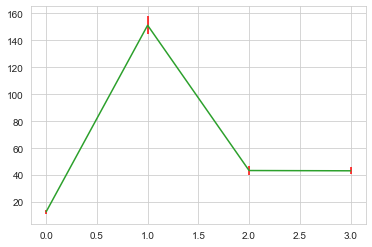

In [92]:
sns.set_style('whitegrid')
plt.errorbar(data= df, x= 'x',  y='mean', yerr='std',               
             ecolor='red', color=sns.color_palette()[2])
plt.show()

In [4]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
     

In [5]:
tanis = Files('./GNPS_15_12_2021_pos_tanimoto_scores.pickle').load_pickle()

In [6]:
tanis.head()

inchikey14,LFTLOKWAGJYHHR,BQDXDGDOYPUUOD,VEPUCZUJLKAVNM,PXPSEALQIQRPQY,HDZVRBPBPCZCJG,SXJIZQPZESTWLD,JDOFZOKGCYYUER,WGTCMJBJRPKENJ,FCCDDURTIIUXBY,FDLLEBFMOIHMNM,...,RJAHLSXSRQXGGI,VKJTXCWIQDBMLE,NFIHKFSODJJLGC,NHLBOKNHQIEJIH,QABASLXUKXNHMC,XGVJWXAYKUHDOO,MNKNQKOOKLVXDB,CQKNELOTFUSOTP,MHCYVCDXRQGUFW,NMCMVEXMLSARCJ
inchikey14,,,,,,,,,,,,,,,,,,,,,
LFTLOKWAGJYHHR,1.000000,0.057353,0.042969,0.053269,0.069264,0.055453,0.048193,0.053296,0.052863,0.056204,...,0.049612,0.054762,0.053929,0.060065,0.049683,0.052980,0.049046,0.095833,0.050964,0.050159
BQDXDGDOYPUUOD,0.057353,1.000000,0.162866,0.215026,0.242169,0.176221,0.296270,0.195915,0.089888,0.460000,...,0.185547,0.430151,0.180851,0.218014,0.321244,0.297297,0.272672,0.147776,0.317369,0.253207
VEPUCZUJLKAVNM,0.042969,0.162866,1.000000,0.286316,0.113158,0.152310,0.208607,0.264908,0.082418,0.186620,...,0.157480,0.167925,0.233333,0.152523,0.228311,0.251228,0.226978,0.080844,0.289835,0.231393
PXPSEALQIQRPQY,0.053269,0.215026,0.286316,1.000000,0.134357,0.185499,0.342992,0.344860,0.081680,0.257655,...,0.243169,0.248216,0.351724,0.207021,0.299073,0.376868,0.351122,0.073363,0.362462,0.374658
HDZVRBPBPCZCJG,0.069264,0.242169,0.113158,0.134357,1.000000,0.145266,0.205817,0.136898,0.102000,0.240987,...,0.139401,0.275825,0.136986,0.157074,0.223055,0.192202,0.190231,0.166329,0.196615,0.175919


In [20]:
tanis.loc['LFTLOKWAGJYHHR', 'VEPUCZUJLKAVNM']

0.04296875

In [16]:
pd.head()

inchikey14,LFTLOKWAGJYHHR,BQDXDGDOYPUUOD,VEPUCZUJLKAVNM,PXPSEALQIQRPQY,HDZVRBPBPCZCJG,SXJIZQPZESTWLD,JDOFZOKGCYYUER,WGTCMJBJRPKENJ,FCCDDURTIIUXBY,FDLLEBFMOIHMNM,...,RJAHLSXSRQXGGI,VKJTXCWIQDBMLE,NFIHKFSODJJLGC,NHLBOKNHQIEJIH,QABASLXUKXNHMC,XGVJWXAYKUHDOO,MNKNQKOOKLVXDB,CQKNELOTFUSOTP,MHCYVCDXRQGUFW,NMCMVEXMLSARCJ
inchikey14,,,,,,,,,,,,,,,,,,,,,
LFTLOKWAGJYHHR,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BQDXDGDOYPUUOD,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEPUCZUJLKAVNM,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PXPSEALQIQRPQY,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HDZVRBPBPCZCJG,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
